In [1]:
from pyspark import SparkContext
sc = SparkContext.getOrCreate()

In [2]:
sc

<SparkContext master=local[*] appName=PySparkShell>

In [3]:
from pyspark.sql.functions import udf
import string
import re
from pyspark.ml.feature import Tokenizer,StopWordsRemover
from pyspark.ml import Pipeline, PipelineModel

In [7]:
review_raw = spark.read.json("/Users/Grace/desktop/msan/msan697/dataset/review.json")

In [34]:
#review_raw =spark.read.format("com.mongodb.spark.sql.DefaultSource").option("uri","mongodb://ec2-34-216-224-27.us-west-2.compute.amazonaws.com/project.review").load()

In [8]:
review = review_raw.select('text','stars')
review_sub = review.sample(False, 0.01, 1)
review_neg = review_sub.filter("stars<3").select("text")
review_pos = review_sub.filter("stars>=4").select("text")

In [9]:
def remove_num_punct(text):
    text = text.lower()
    my_string = text.replace("-", " ")
    regex = re.compile('[' + re.escape(string.punctuation) + '0-9\\r\\t\\n]')
    nopunct = regex.sub(" ", my_string)  # delete stuff but leave at least a space to avoid clumping together
    return nopunct

udf_num_punct = udf(lambda x:remove_num_punct(x))

In [10]:
def bi_gram(words):
    words = [w for w in words if len(w) > 0]
    bigram = [" ".join([words[i],words[i+1]])for i in range(len(words)-1)]
    return bigram

In [11]:
def tri_gram(words):
    words = [w for w in words if len(w) > 0]
    trigram = [" ".join([words[i],words[i+1],words[i+2]])for i in range(len(words)-2)]
    return trigram

In [12]:
tokenizer = Tokenizer(inputCol="text", outputCol="words")
remover = StopWordsRemover(inputCol="words", outputCol="filtered", caseSensitive=False)
pipeline=Pipeline(stages=[tokenizer,remover])

## Positive Review

In [13]:
review_pos = review_pos.select(udf_num_punct('text').alias('text'))
pos_words=pipeline.fit(review_pos).transform(review_pos).select("filtered")
pos_rdd= pos_words.rdd.map(list).map(lambda x:x[0]).cache()

In [14]:
pos_uni=pos_rdd.flatMap(lambda words: [w for w in words if len(w) > 0])
top_pos_uni = pos_uni.map(lambda x: (x,1)).reduceByKey(lambda x,y: x+y).sortBy(lambda x: x[1], ascending=False)
top_pos_uni.collect()[0:20]

[(u'great', 17113),
 (u'good', 15245),
 (u'place', 15176),
 (u'food', 14014),
 (u'service', 9924),
 (u'time', 9713),
 (u'like', 9644),
 (u'one', 9004),
 (u'get', 8778),
 (u'really', 7845),
 (u'go', 7744),
 (u'back', 7718),
 (u'also', 7211),
 (u'best', 6767),
 (u've', 6548),
 (u'love', 6305),
 (u'always', 6182),
 (u'nice', 6067),
 (u'well', 5884),
 (u'friendly', 5722)]

In [15]:
pos_bi= pos_rdd.flatMap(lambda x: bi_gram(x))
top_pos_bi = pos_bi.map(lambda x: (x,1)).reduceByKey(lambda x,y: x+y).sortBy(lambda x: x[1], ascending=False)
top_pos_bi.collect()[0:20]

[(u'highly recommend', 1559),
 (u'first time', 1261),
 (u'customer service', 1094),
 (u'really good', 1072),
 (u'go back', 1065),
 (u'come back', 1064),
 (u'great place', 941),
 (u'great service', 939),
 (u'las vegas', 931),
 (u'ice cream', 890),
 (u'next time', 871),
 (u'love place', 870),
 (u'great food', 867),
 (u've ever', 834),
 (u'every time', 798),
 (u'one best', 774),
 (u'staff friendly', 767),
 (u'happy hour', 758),
 (u'food great', 751),
 (u'pretty good', 746)]

In [17]:
pos_tri= pos_rdd.flatMap(lambda x: tri_gram(x))
top_pos_tri = pos_tri.map(lambda x: (x,1)).reduceByKey(lambda x,y: x+y).sortBy(lambda x: x[1], ascending=False)
top_pos_tri.collect()[0:20]

[(u'definitely come back', 235),
 (u'great customer service', 225),
 (u'definitely go back', 218),
 (u'wait go back', 190),
 (u'definitely coming back', 177),
 (u'highly recommend place', 167),
 (u'great food great', 163),
 (u'best ve ever', 159),
 (u'food great service', 158),
 (u'mac n cheese', 133),
 (u'service great food', 123),
 (u'next time m', 121),
 (u'back next time', 119),
 (u'love love love', 118),
 (u'definitely going back', 111),
 (u'staff always friendly', 110),
 (u'staff super friendly', 108),
 (u'sweet potato fries', 107),
 (u'wait come back', 107),
 (u'every time go', 103)]

## Negative Review

In [18]:
review_neg = review_neg.select(udf_num_punct('text').alias('text'))
neg_words=pipeline.fit(review_neg).transform(review_neg).select("filtered")
neg_rdd= neg_words.rdd.map(list).map(lambda x:x[0]).cache()

In [19]:
neg_uni=neg_rdd.flatMap(lambda words: [w for w in words if len(w) > 0])
top_neg_uni = neg_uni.map(lambda x: (x,1)).reduceByKey(lambda x,y: x+y).sortBy(lambda x: x[1], ascending=False)
top_neg_uni.collect()[0:20]

[(u'food', 6400),
 (u'place', 5383),
 (u'get', 5241),
 (u'like', 5028),
 (u'service', 4932),
 (u'one', 4906),
 (u'back', 4788),
 (u'time', 4769),
 (u'good', 4048),
 (u'us', 3875),
 (u'go', 3698),
 (u'even', 3582),
 (u'said', 3352),
 (u'never', 3242),
 (u'didn', 3085),
 (u'got', 3065),
 (u'told', 2910),
 (u'came', 2706),
 (u'order', 2644),
 (u'really', 2558)]

In [20]:
neg_bi= neg_rdd.flatMap(lambda x: bi_gram(x))
top_neg_bi = neg_bi.map(lambda x: (x,1)).reduceByKey(lambda x,y: x+y).sortBy(lambda x: x[1], ascending=False)
top_neg_bi.collect()[0:20]

[(u'customer service', 1084),
 (u'go back', 594),
 (u'first time', 462),
 (u'come back', 438),
 (u'even though', 355),
 (u'didn even', 336),
 (u'tasted like', 327),
 (u'came back', 298),
 (u'going back', 281),
 (u'front desk', 278),
 (u'much better', 275),
 (u'told us', 269),
 (u've ever', 267),
 (u'last time', 262),
 (u'never go', 260),
 (u'looked like', 258),
 (u'every time', 243),
 (u'las vegas', 232),
 (u'coming back', 229),
 (u'one star', 229)]

In [21]:
neg_tri= neg_rdd.flatMap(lambda x: tri_gram(x))
top_neg_tri = neg_tri.map(lambda x: (x,1)).reduceByKey(lambda x,y: x+y).sortBy(lambda x: x[1], ascending=False)
top_neg_tri.collect()[0:20]

[(u'never go back', 150),
 (u'worst customer service', 85),
 (u'go somewhere else', 71),
 (u'poor customer service', 69),
 (u'horrible customer service', 65),
 (u'long story short', 65),
 (u'waste time money', 58),
 (u'never going back', 52),
 (u'won going back', 52),
 (u'never come back', 48),
 (u'give zero stars', 46),
 (u'took minutes get', 45),
 (u'worst service ever', 45),
 (u'never coming back', 44),
 (u'asked speak manager', 41),
 (u'really wanted like', 41),
 (u'won go back', 40),
 (u'terrible customer service', 40),
 (u'wanted like place', 40),
 (u'customer service ever', 40)]

## Look at one business

In [22]:
biz_raw = spark.read.json("/Users/Grace/desktop/msan/msan697/dataset/business.json")

In [23]:
# select the restaurants with the most number of reviews, seems that they are all from LV - high class buffet
biz_raw.sort('review_count',ascending = False).select('name','review_count','city').show(truncate=False)

+--------------------------------+------------+---------+
|name                            |review_count|city     |
+--------------------------------+------------+---------+
|Mon Ami Gabi                    |6979        |Las Vegas|
|Bacchanal Buffet                |6417        |Las Vegas|
|Wicked Spoon                    |5632        |Las Vegas|
|Gordon Ramsay BurGR             |5429        |Las Vegas|
|Earl of Sandwich                |4789        |Las Vegas|
|Hash House A Go Go              |4371        |Las Vegas|
|Serendipity 3                   |3913        |Las Vegas|
|The Buffet                      |3873        |Las Vegas|
|Lotus of Siam                   |3838        |Las Vegas|
|The Buffet at Bellagio          |3700        |Las Vegas|
|ARIA Resort & Casino            |3634        |Las Vegas|
|The Cosmopolitan of Las Vegas   |3621        |Las Vegas|
|Secret Pizza                    |3542        |Las Vegas|
|Bouchon at the Venezia Tower    |3439        |Las Vegas|
|Luxor Hotel a

In [24]:
# select a business, 'Wicked Spoon', and look for its business_id
biz_raw.filter("name like '%Wicked Spoon%'").select('business_id').show(truncate=False)

+----------------------+
|business_id           |
+----------------------+
|K7lWdNUhCbcnEvI0NhGewg|
+----------------------+



In [27]:
# filter out the reviews of this restaurant
biz = review_raw.filter("business_id like '%K7lWdNUhCbcnEvI0NhGewg%'").select("text")

In [28]:
biz.show()

+--------------------+
|                text|
+--------------------+
|One of the better...|
|gourmet normal fo...|
|In terms of buffe...|
|I would definitel...|
|The most amazing ...|
|I dont frequent b...|
|By far, one of th...|
|4.5 stars.  This ...|
|In my opinion thi...|
|Exhausted after a...|
|Large groups requ...|
|My Hubby and I we...|
|Was a fan before,...|
|Sehr gutes Buffet...|
|Came here for bru...|
|We went on a Mond...|
|Decided to come h...|
|Waited much too l...|
|What am amazing b...|
|5/5 highly recomm...|
+--------------------+
only showing top 20 rows



In [29]:
review_biz = biz.select(udf_num_punct('text').alias('text'))
biz_words=pipeline.fit(review_biz).transform(review_biz).select("filtered")
words_rdd= biz_words.rdd.map(list).map(lambda x:x[0]).cache()

In [30]:
words_rdd.take(5)

[[u'one',
  u'better',
  u'buffets',
  u'vegas',
  u'',
  u'',
  u'almost',
  u'',
  u'',
  u'',
  u'',
  u'dinner',
  u'',
  u'carefully',
  u'prepared',
  u'foods',
  u'',
  u'',
  u'pleasing',
  u'eyes',
  u'',
  u'nose',
  u'',
  u'tongue',
  u'',
  u'',
  u'get',
  u'gelato',
  u'',
  u'various',
  u'flavors',
  u'',
  u'smoked',
  u'salmon',
  u'slices',
  u'',
  u'',
  u'minus',
  u'one',
  u'star',
  u'',
  u'disgusted',
  u'spilled',
  u'beer',
  u'register',
  u'counter',
  u'ground',
  u'',
  u'',
  u'rested',
  u'elbow',
  u'one',
  u'end',
  u'',
  u'smell',
  u'beer',
  u'lingered',
  u'throughout',
  u'dinner',
  u'',
  u'',
  u'blegh'],
 [u'gourmet',
  u'normal',
  u'food',
  u'',
  u'',
  u'',
  u'',
  u'presentation',
  u'dishes',
  u'tapas',
  u'style',
  u'mini',
  u'pots',
  u'pans',
  u'containing',
  u'expertly',
  u'crafted',
  u'dishes',
  u'',
  u'',
  u'used',
  u'mushroom',
  u'cooked',
  u'reduced',
  u'wine',
  u'sauce',
  u'favorite',
  u'dish',
  u'didn'

In [31]:
biz_uni=words_rdd.flatMap(lambda words: [w for w in words if len(w) > 0])
top_biz_uni = neg_uni.map(lambda x: (x,1)).reduceByKey(lambda x,y: x+y).sortBy(lambda x: x[1], ascending=False)
top_biz_uni.collect()[0:20]

[(u'food', 6400),
 (u'place', 5383),
 (u'get', 5241),
 (u'like', 5028),
 (u'service', 4932),
 (u'one', 4906),
 (u'back', 4788),
 (u'time', 4769),
 (u'good', 4048),
 (u'us', 3875),
 (u'go', 3698),
 (u'even', 3582),
 (u'said', 3352),
 (u'never', 3242),
 (u'didn', 3085),
 (u'got', 3065),
 (u'told', 2910),
 (u'came', 2706),
 (u'order', 2644),
 (u'really', 2558)]

In [33]:
biz_list = biz_uni.collect()

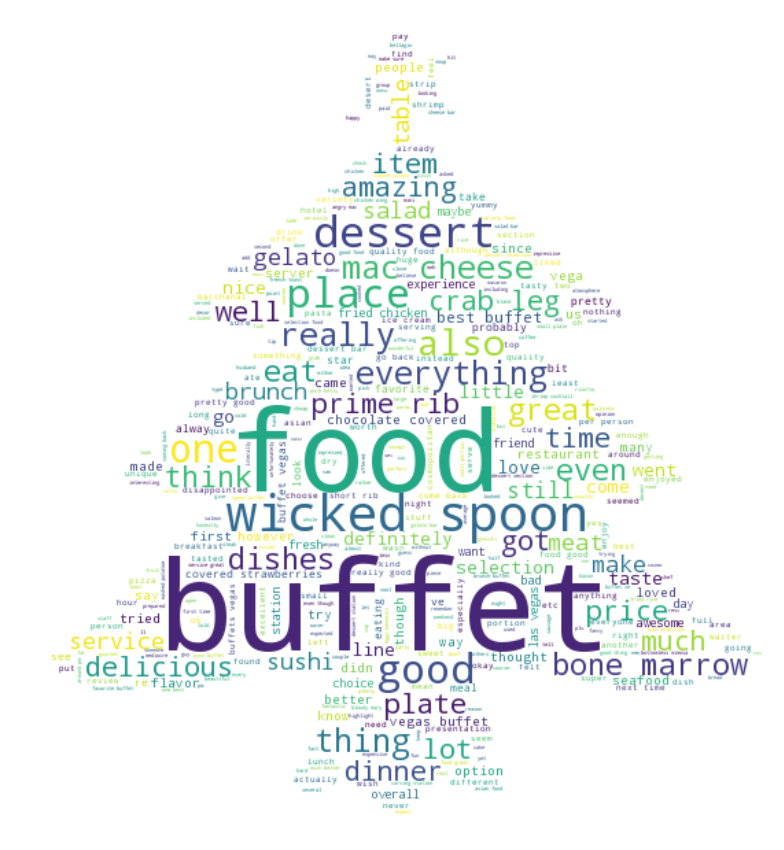

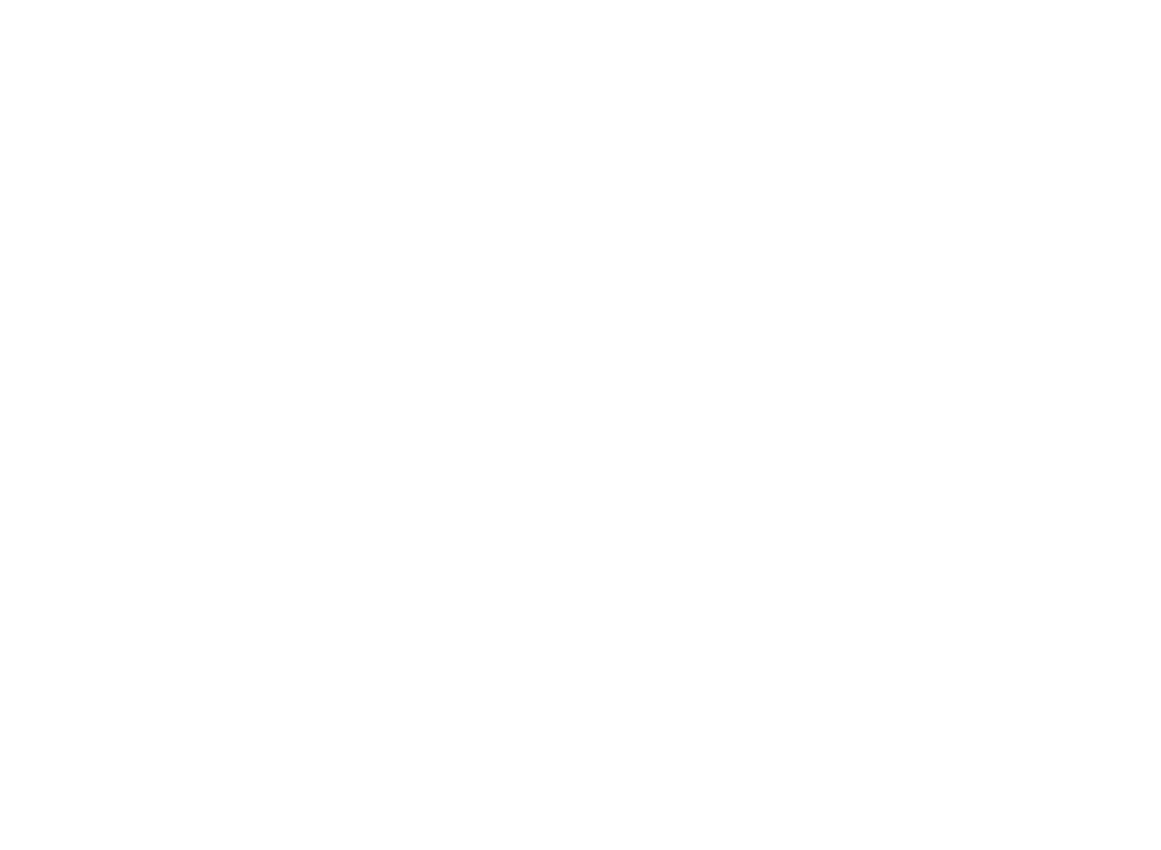

In [34]:
from os import path
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt

from wordcloud import WordCloud, STOPWORDS

# Read the whole text.
#text = open('alice.txt').read()
text = " ".join(biz_list) #read in review text

# read the mask image
# taken from
# http://www.stencilry.org/stencils/movies/alice%20in%20wonderland/255fk.jpg
alice_mask = np.array(Image.open("tree5.png"))

stopwords = set(STOPWORDS)
stopwords.add("said")

wc = WordCloud(background_color="white",width=2000, height=1000,  max_words=2000, mask=alice_mask,
               stopwords=stopwords)
# generate word cloud
wc.generate(text)

# store to file
wc.to_file("alice.png")

# show
plt.figure(figsize=(20, 15))
plt.imshow(wc, interpolation='bilinear')
plt.axis("off")
plt.figure(figsize=(20, 15))
plt.axis("off")
plt.show()